# Data Analysis
---
At this Jupiter Notebook you can find some analysis of primary dataset for working with classificaton/tagging task. <br>
Within this notebook you able to understand train of thought about processing source data and choosing models. 

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
import os

In [2]:
module_path = os.path.abspath(os.path.join('..')) # Path to root folder
if module_path not in sys.path:
    sys.path.append(module_path + "/scripts") # define scripts path

from ipynb_func import *

### 1. Raw data analysis

For now, let's check our raw data for some useful information.

Data loader:

In [3]:
NUM = 10 # Number of data parquets to use

assert NUM >= 1 and NUM <= 10, "NUM value must be in range [1, 10]"
paths = [module_path + f"/data/pikabu/raw/000{i}.parquet" for i in range(NUM)] # Making list of roots to merge 

data = merge_dataset(paths)

In [4]:
data.head(2)

,id,title,text_markdown,timestamp,author_id,username,rating,pluses,minuses,url,tags,blocks,comments
0,6991642,Что можно купить в Китае за цену нового iPhone...,Осенью в России стартовали продажи очередной м...,1571221527,2900955,chinatoday.ru,-4,9,13,https://pikabu.ru/story/chto_mozhno_kupit_v_ki...,"[Китай, AliExpress, Китайские товары, Бизнес, ...",{'data': ['<p>Осенью в России стартовали прода...,"{'id': [152116588, 152116426, 152114895, 15211..."
1,7178566,Последний оставшийся в живых освободитель Осве...,В канун 75-летия освобождения концлагеря и V В...,1579586602,1723707,sssr24,1339,1498,159,https://pikabu.ru/story/posledniy_ostavshiysya...,"[Великая Отечественная война, Чтобы помнили, О...",{'data': ['<p>В канун 75-летия освобождения ко...,"{'id': [159479910, 159460617, 159469842, 15947..."


In [5]:
print("Total length of dataset =", len(data))

Total length of dataset = 279000


In [6]:
""" 
It is suggested to look at the dataset, starting with the most recent posts. 
If necessary, the oldest posts can be easily ignored.
"""

data.sort_values(by=['timestamp'], inplace=True, ascending=False)
data.reset_index(inplace=True)
data.drop(['index'], axis='columns', inplace=True)
data.head(2)

,id,title,text_markdown,timestamp,author_id,username,rating,pluses,minuses,url,tags,blocks,comments
0,7459063,От патрона до…,,1589869418,2569119,KiteRunner,0,0,0,https://pikabu.ru/story/ot_patrona_do_7459063,"[Магазин, Комментарии, Универсальный, Скриншот]",{'data': ['https://cs11.pikabu.ru/post_img/big...,"{'id': [], 'timestamp': [], 'parent_id': [], '..."
1,7459038,А вы знаете этих великих сыщиков?,,1589868662,3093826,Olgapaniseva,0,0,0,https://pikabu.ru/story/a_vyi_znaete_yetikh_ve...,"[Книги, Киногерои, Длиннопост]",{'data': ['https://cs13.pikabu.ru/post_img/big...,"{'id': [], 'timestamp': [], 'parent_id': [], '..."


In [7]:
last_post_time = datetime.fromtimestamp(data.timestamp[0])
first_post_time = datetime.fromtimestamp(data.timestamp[len(data)-1])

print("Time of the latest post in dataset:",  last_post_time)
print("Time of the oldest post in dataset:", first_post_time)

Time of the latest post in dataset: 2020-05-19 09:23:38
Time of the oldest post in dataset: 2011-12-28 15:46:13


The following assumption is made:  
>The greatest interest in this dataset is the collection of the following columns:  
    >- Post title and post content  
    >- Tags corresponding to the post  
    >- Link to post for correct debugging and comparison  

In [8]:
data = data[['title', 'text_markdown', 'url','tags']]
data.head(4)

,title,text_markdown,url,tags
0,От патрона до…,,https://pikabu.ru/story/ot_patrona_do_7459063,"[Магазин, Комментарии, Универсальный, Скриншот]"
1,А вы знаете этих великих сыщиков?,,https://pikabu.ru/story/a_vyi_znaete_yetikh_ve...,"[Книги, Киногерои, Длиннопост]"
2,Ахтунг !! Видео вызывает смешанные чувства,,https://pikabu.ru/story/akhtung__video_vyizyiv...,"[Тюмень, Трюкачи, Авто, Видео]"
3,Коротко о ситуации в стране,Украдено с YouTube.,https://pikabu.ru/story/korotko_o_situatsii_v_...,"[Коронавирус, Полиция, Пацаки, Видео]"


In [9]:
APPEAR_AT_LEAST = 50

tg = getwordlist(data.tags)
tg_cnt = getworddict(tg, at_least=1)

assert APPEAR_AT_LEAST >= 1 and APPEAR_AT_LEAST <= max(tg_cnt.values()), f"Value must be in range [1, {max(tg_cnt.values())}]."

tg_cnt_cond = getworddict(tg, at_least=APPEAR_AT_LEAST)

print("Total number of tags in full dataset:", len(tg_cnt))
print(f"Number of tags in full dataset that appear more than {APPEAR_AT_LEAST} times: {len(tg_cnt_cond)}")

Total number of tags in full dataset: 81675
Number of tags in full dataset that appear more than 50 times: 2734


It is also proposed to consider posts of dataset in which the content is not empty:

In [10]:
data_with_txt = data[data.text_markdown != '']
data_with_txt.head(4)

,title,text_markdown,url,tags
3,Коротко о ситуации в стране,Украдено с YouTube.,https://pikabu.ru/story/korotko_o_situatsii_v_...,"[Коронавирус, Полиция, Пацаки, Видео]"
5,Совсем крыша поехала из-за COVID-19,Ищу работу в СПб.\nЕсть пару моментов с матом*,https://pikabu.ru/story/sovsem_kryisha_poekhal...,"[World of Warcraft, Поиск работы, Бездельники,..."
6,Тем кто ложится спать-спокойного сна,Колыбельная,https://pikabu.ru/story/tem_kto_lozhitsya_spat...,"[Скриншот, Колыбельная, Ужас]"
8,Серёжки,"Моя подруга Любка, кладезь оптимизма и хорошег...",https://pikabu.ru/story/seryozhki_7458784,"[Реальная история из жизни, Тонкий юмор, Ох уж..."


In [11]:
print("Total length of dataset w/out empty text fields =", len(data_with_txt))

Total length of dataset w/out empty text fields = 164644


In [12]:
et_tg = getwordlist(data_with_txt.tags)
et_tg_cnt = getworddict(et_tg, at_least=1)
et_tg_cnt_cond = getworddict(et_tg, at_least=APPEAR_AT_LEAST)

print("Total number of tags in dataset with no missing text fields:", len(et_tg_cnt))
print(f"Number of tags in dataset with no missing text fields that appear more than {APPEAR_AT_LEAST} times: {len(et_tg_cnt_cond)}")

Total number of tags in dataset with no missing text fields: 60006
Number of tags in dataset with no missing text fields that appear more than 50 times: 1892


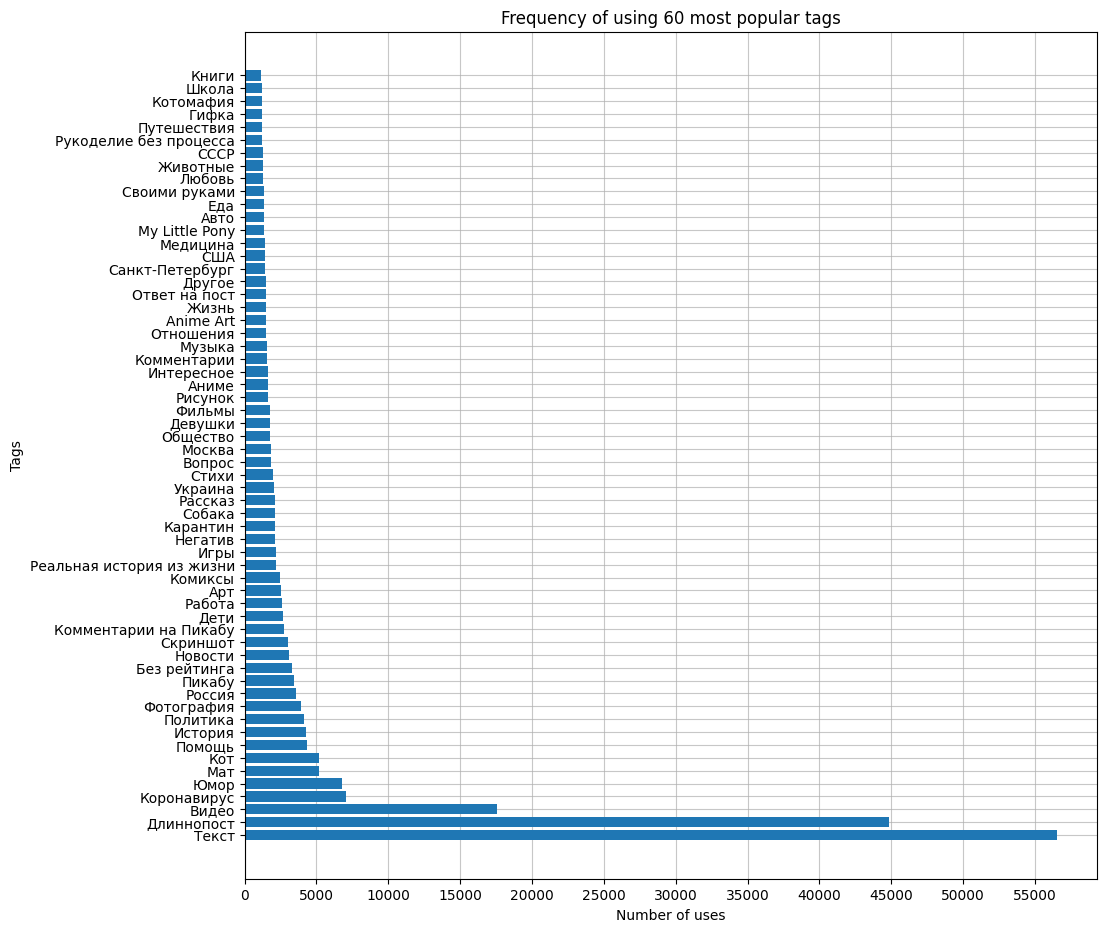

In [13]:
word = list(et_tg_cnt_cond.keys())
count = list(et_tg_cnt_cond.values())

N_MOST_POPULAR = 60 # Set the value based on how many top tags you want to receive

assert N_MOST_POPULAR <= len(count) and N_MOST_POPULAR > 0, f"N_MOST_POPULAR value must be in range [1, {len(count)}]."

raw_fig, ax = plt.subplots(figsize=(11,11))

ax.grid(zorder=1, alpha=0.7)
ax.barh(word[0:N_MOST_POPULAR], count[0:N_MOST_POPULAR], zorder=2)
ax.set_xticks(np.arange(0, max(count), 5000))
ax.set_xlabel("Number of uses")
ax.set_ylabel("Tags")
ax.set_title(f"Frequency of using {N_MOST_POPULAR} most popular tags");

### 2. Analysis of filtered data

And now let's check out new filtered data, where posts containing photographs and/or videos were excluded where possible:

In [14]:
filtered_paths = [module_path + f"/data/pikabu/filtered_data/not_processed_v1/{i}_processed.parquet" for i in range(NUM)] # Making list of roots to merge 
filtered_data = merge_dataset(filtered_paths)

In [15]:
filtered_data.head(2)

,title,text_markdown,pluses,minuses,id,author_id,username,url,tags
7,Рассада...,Аня: У тебя волосы в носу растут?\nПетя: Нет!\...,5,14,2936217,453525,Misochkin,https://pikabu.ru/story/rassada_2936217,Петр;Анна;Рассада;Волосы;Текст;Переписка;Знако...
11,Про начальников и обеды,Недавно родственница жаловалась на дурдом на р...,681,40,6991412,1699826,FluffyMagpie,https://pikabu.ru/story/pro_nachalnikov_i_obed...,Начальник;Руководитель;Обед;Еда;Сотрудники;Текст


In [16]:
print("Total length of filtered dataset =", len(filtered_data))

Total length of filtered dataset = 71626


Let's bring it to a general form:

In [17]:
filtered_data = filtered_data[['title', 'text_markdown', 'url', 'tags']]
filtered_data = filtered_data[filtered_data.text_markdown != '']
filtered_data.tags = formateTags(filtered_data)
filtered_data.head(2)

,title,text_markdown,url,tags
7,Рассада...,Аня: У тебя волосы в носу растут?\nПетя: Нет!\...,https://pikabu.ru/story/rassada_2936217,"[Петр, Анна, Рассада, Волосы, Текст, Переписка..."
11,Про начальников и обеды,Недавно родственница жаловалась на дурдом на р...,https://pikabu.ru/story/pro_nachalnikov_i_obed...,"[Начальник, Руководитель, Обед, Еда, Сотрудник..."


Number of tags in filtered dataset:

In [18]:
filtered_tg = getwordlist(filtered_data.tags)
filtered_tg_cnt = getworddict(filtered_tg, at_least=1)
filtered_tg_cnt_cond = getworddict(filtered_tg, at_least=APPEAR_AT_LEAST)

print("Total number of tags in filtered dataset with no missing text fields:", len(filtered_tg_cnt))
print(f"Number of tags in filtered dataset with no missing text fields that appear more than {APPEAR_AT_LEAST} times: {len(filtered_tg_cnt_cond)}")

Total number of tags in filtered dataset with no missing text fields: 28246
Number of tags in filtered dataset with no missing text fields that appear more than 50 times: 665


As a result we have the following distribution of tags:

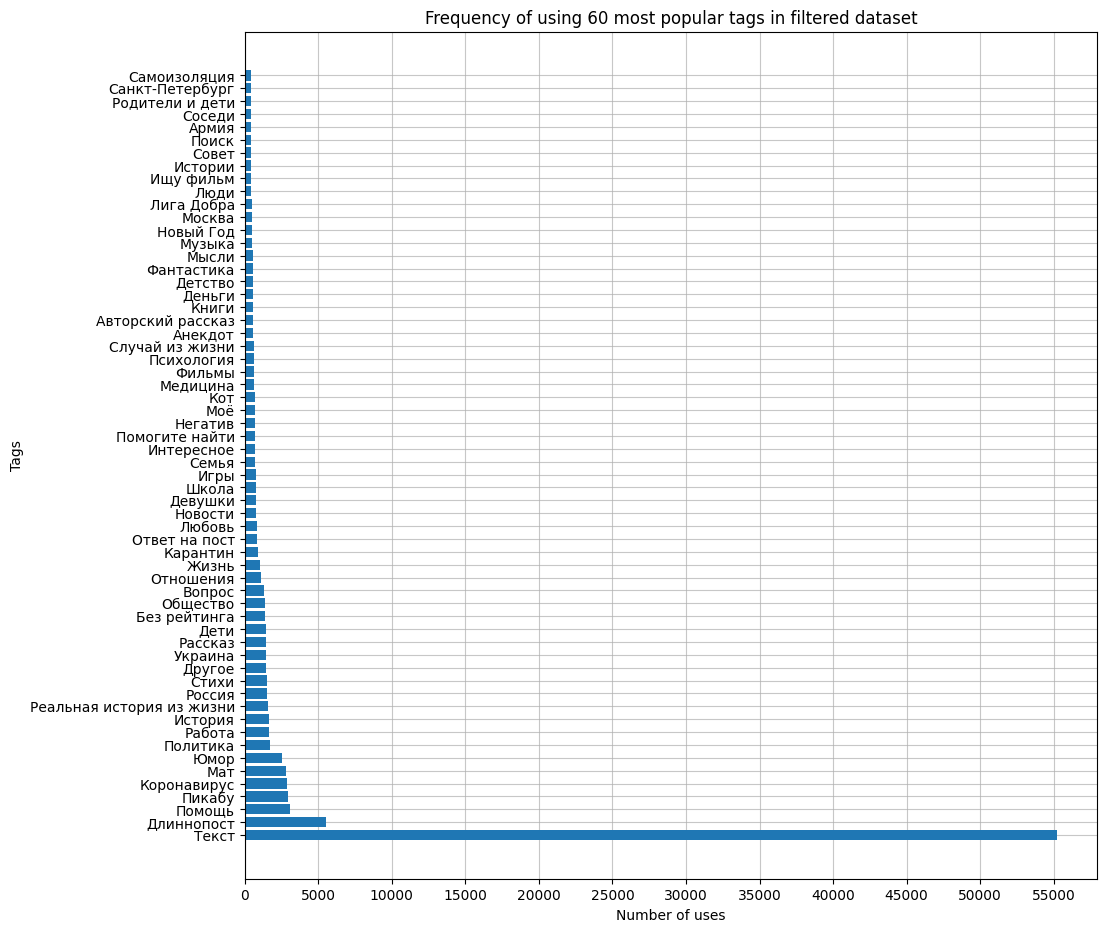

In [19]:
filtered_word = list(filtered_tg_cnt_cond.keys())
filtered_count = list(filtered_tg_cnt_cond.values())

filtered_fig, ax = plt.subplots(figsize=(11,11))

ax.grid(zorder=1, alpha=0.7)
ax.barh(filtered_word[0:N_MOST_POPULAR], filtered_count[0:N_MOST_POPULAR], zorder=2)
ax.set_xticks(np.arange(0, max(filtered_count), 5000))
ax.set_xlabel("Number of uses")
ax.set_ylabel("Tags")
ax.set_title(f"Frequency of using {N_MOST_POPULAR} most popular tags in filtered dataset");

### 3. Summary

In the end, we have the following:

In [20]:
from tabulate import tabulate

tab_data = [['Total length of dataset', len(data), len(data_with_txt), len(filtered_data)],
            ['Total number of tags', len(tg_cnt), len(et_tg_cnt), len(filtered_tg_cnt)],
            [f'Number of tags, that appear more that {N_MOST_POPULAR} times', len(tg_cnt_cond), len(et_tg_cnt_cond), len(filtered_tg_cnt_cond)]]
col_names = ['Raw Data', 'Raw Data w/out empty posts', 'Filtered Data w/out empty posts']

print(tabulate(tab_data, headers=col_names, tablefmt='fancy_grid'))

╒════════════════════════════════════════════════╤════════════╤══════════════════════════════╤═══════════════════════════════════╕
│                                                │   Raw Data │   Raw Data w/out empty posts │   Filtered Data w/out empty posts │
╞════════════════════════════════════════════════╪════════════╪══════════════════════════════╪═══════════════════════════════════╡
│ Total length of dataset                        │     279000 │                       164644 │                             69292 │
├────────────────────────────────────────────────┼────────────┼──────────────────────────────┼───────────────────────────────────┤
│ Total number of tags                           │      81675 │                        60006 │                             28246 │
├────────────────────────────────────────────────┼────────────┼──────────────────────────────┼───────────────────────────────────┤
│ Number of tags, that appear more that 60 times │       2734 │                    

Also we highlight those tags, that seems to be not in our insterest:

In [21]:
# not problematic, but tags, that are not in our interests and not contain topic information
tags_to_remove = ['Длиннопост', 'Текст', 'Без рейтинга', 'Ответ на пост', 'Комментарии', 'Моё', 'Пикабу'] 

Final tags distribution:

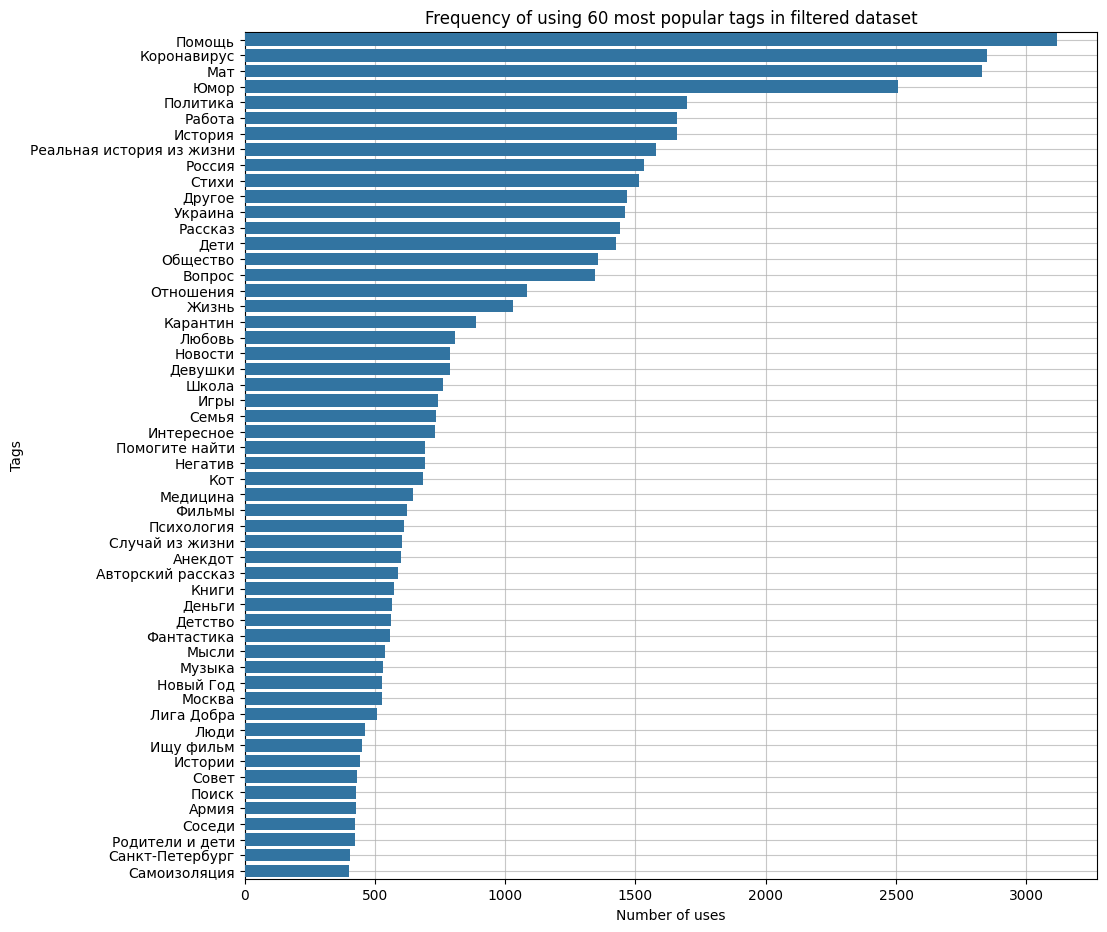

In [22]:
mask = [True if (i not in tags_to_remove) else False for i in filtered_word][0:N_MOST_POPULAR]
pltdf = pd.DataFrame()
pltdf['filtered_word'] = filtered_word[0:N_MOST_POPULAR]
pltdf['filtered_count'] = filtered_count[0:N_MOST_POPULAR]
pltdf = pltdf[mask]

filtered_fig, ax = plt.subplots(figsize=(11,11))
sns.barplot(pltdf, x = 'filtered_count', y='filtered_word', legend=False, zorder=5)
ax.set_xticks(np.arange(0, max(pltdf['filtered_count']), 500))
ax.grid(zorder=1, alpha=0.7)
ax.set_ylabel("Tags")
ax.set_xlabel("Number of uses")
ax.set_title(f"Frequency of using {N_MOST_POPULAR} most popular tags in filtered dataset");

Save top `N_MOST_POPULAR` tags into file for future use:

In [23]:
top_tags = word[0:N_MOST_POPULAR] # Top {N_MOST_POPULAR} tags in data w/out empty text fields
filtered_top_tags = filtered_word[0:N_MOST_POPULAR] # Top {N_MOST_POPULAR} tags in filtered data

txt_path = module_path + '/data/'
with open(txt_path + 'top_tags.txt', 'w') as f: # Saving txt for data in pikabu/processed
    for line in top_tags:
        f.write(line)
        f.write('\n')

with open(txt_path + 'filtered_top_tags.txt', 'w') as f: # Saving txt for data in pikabu/filtered_data/processed_v2
    for line in filtered_top_tags:
        f.write(line)
        f.write('\n')